In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression

DATA = Path("../data/processed/ethiopia_fi_unified_data_enriched.xlsx")

df = pd.read_excel(DATA)
df["observation_date"] = pd.to_datetime(df["observation_date"], errors="coerce")

obs = df[df["record_type"] == "observation"].copy()
obs["year"] = obs["observation_date"].dt.year


In [3]:
access = obs[obs["indicator_code"] == "account_ownership_pct"].dropna(subset=["year"])
usage = obs[obs["indicator_code"] == "digital_payment_pct"].dropna(subset=["year"])


In [4]:
def linear_forecast(df, years_ahead=3):
    X = df["year"].values.reshape(-1, 1)
    y = df["value_numeric"].values

    model = LinearRegression()
    model.fit(X, y)

    future_years = np.arange(X.max() + 1, X.max() + years_ahead + 1)
    preds = model.predict(future_years.reshape(-1, 1))

    return pd.DataFrame({
        "year": future_years,
        "forecast": preds
    })


In [6]:
obs["indicator_code"].value_counts()


indicator_code
ACC_OWNERSHIP         6
ACC_FAYDA             3
ACC_4G_COV            2
ACC_MM_ACCOUNT        2
GEN_GAP_ACC           2
USG_P2P_COUNT         2
ACC_MOBILE_PEN        1
USG_P2P_VALUE         1
USG_ATM_VALUE         1
USG_CROSSOVER         1
USG_TELEBIRR_USERS    1
USG_ATM_COUNT         1
USG_TELEBIRR_VALUE    1
USG_MPESA_USERS       1
USG_ACTIVE_RATE       1
USG_MPESA_ACTIVE      1
AFF_DATA_INCOME       1
GEN_MM_SHARE          1
GEN_GAP_MOBILE        1
mm_active_pct         1
Name: count, dtype: int64

In [7]:
obs[obs["indicator"].str.contains("account", case=False, na=False)][
    ["indicator", "indicator_code"]
].drop_duplicates()


,indicator,indicator_code
0,Account Ownership Rate,ACC_OWNERSHIP
6,Mobile Money Account Rate,ACC_MM_ACCOUNT
26,Account Ownership Gender Gap,GEN_GAP_ACC
28,Female Mobile Money Account Share,GEN_MM_SHARE
43,Active mobile money accounts (% of adults),mm_active_pct


In [8]:
obs[obs["indicator"].str.contains("digital", case=False, na=False)][
    ["indicator", "indicator_code"]
].drop_duplicates()


,indicator,indicator_code
11,Fayda Digital ID Enrollment,ACC_FAYDA


In [9]:
def get_indicator(df, keyword):
    subset = df[
        df["indicator"].str.contains(keyword, case=False, na=False)
        & df["value_numeric"].notna()
    ].copy()

    if subset.empty:
        raise ValueError(f"No data found for indicator containing '{keyword}'")

    subset["year"] = subset["observation_date"].dt.year
    subset = subset.dropna(subset=["year"])

    return subset


In [10]:
access = get_indicator(obs, "account")
usage = get_indicator(obs, "digital")


In [11]:
def linear_forecast(df, years_ahead=3):
    X = df["year"].values.reshape(-1, 1)
    y = df["value_numeric"].values

    model = LinearRegression()
    model.fit(X, y)

    future_years = np.arange(X.max() + 1, X.max() + years_ahead + 1)
    preds = model.predict(future_years.reshape(-1, 1))

    return pd.DataFrame({
        "year": future_years,
        "forecast": preds
    })


In [12]:
access_fc = linear_forecast(access, 3)
usage_fc = linear_forecast(usage, 3)


In [14]:
def apply_scenario(df, scenario):
    df = df.copy()
    if scenario == "optimistic":
        df["forecast"] *= 1.15
    elif scenario == "pessimistic":
        df["forecast"] *= 0.85
    return df

access_base = access_fc
access_opt = apply_scenario(access_fc, "optimistic")
access_pes = apply_scenario(access_fc, "pessimistic")


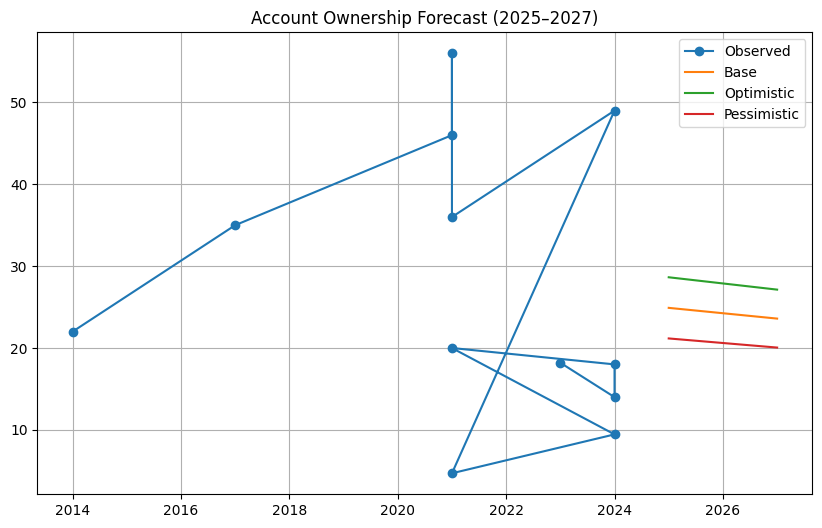

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(access["year"], access["value_numeric"], marker="o", label="Observed")
plt.plot(access_base["year"], access_base["forecast"], label="Base")
plt.plot(access_opt["year"], access_opt["forecast"], label="Optimistic")
plt.plot(access_pes["year"], access_pes["forecast"], label="Pessimistic")
plt.legend()
plt.title("Account Ownership Forecast (2025–2027)")
plt.grid(True)
plt.show()


## Forecast Interpretation

- Baseline suggests gradual improvement
- Optimistic scenario requires strong regulatory and infrastructure momentum
- Pessimistic scenario reflects stalled reforms or adoption friction

### Key Uncertainties
- Speed of mobile money interoperability
- Regulatory openness
- Infrastructure reliability
